# Speech Emotion Recognition With Convolutional Neural Network

# Content
1. [Including Libraries](#1)
2. [Including the Datasets](#2)
3. [Data Analyze](#3)
    * [Audio Augmentation](#7)
        * [Original Audio](#4)
        * [Noised Audio](#8)
        * [Streched Audio](#10)
        * [Shifted Audio](#11)
        * [Pitched Audio](#12)
    * [Feature Extraction](#13)
    * [Processing](#14)
4. [Including Analyzed Audio Features](#15)
5. [Processing Analyzed Data for Training](#16)
    * [Train, Test and Validation Spliting](#17)
    * [Tuning for Training](#18)
6. [Begin Training](#19)
7. [Drawing Charts](#20)
    * [Accuracy Charts](#21)
    * [Loss Charts](#22)
8. [Testing Model and Test Results](#24)
    * [Confusion Matrix](#25)

<a id="1"></a>
# Including Libraries

In [41]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import librosa
import librosa.display
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
import seaborn as sns
import IPython
import tensorflow.keras.layers as L
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
#from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder,StandardScaler
import re
import itertools
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

<a id="2"></a>
# Including the Datasets

In [42]:
Crema_Path='../input/speech-emotion-recognition-en/Crema/'
Ravdess_Path='../input/speech-emotion-recognition-en/Ravdess/audio_speech_actors_01-24'
Savee_Path='../input/speech-emotion-recognition-en/Savee/'
Tess_Path='../input/speech-emotion-recognition-en/Tess/'
subesco_path = '/kaggle/input/subescobangla-speech-emotion-dataset/SUBESCO'

<a id="3"></a>
# Data Analyze

In [43]:
crema=[]
for wav in os.listdir(Crema_Path):
    emotion=wav.partition(".wav")[0].split('_')
    if emotion[2]=='SAD':
        crema.append(('sad',Crema_Path+'/'+wav))
    elif emotion[2]=='ANG':
        crema.append(('angry',Crema_Path+'/'+wav))
    elif emotion[2]=='DIS':
        crema.append(('disgust',Crema_Path+'/'+wav))
    elif emotion[2]=='FEA':
        crema.append(('fear',Crema_Path+'/'+wav))
    elif emotion[2]=='HAP':
        crema.append(('happy',Crema_Path+'/'+wav))
    elif emotion[2]=='NEU':
        crema.append(('neutral',Crema_Path+'/'+wav))
    else:
        crema.append(('unknown',Crema_Path+'/'+wav))
Crema_df=pd.DataFrame.from_dict(crema)
Crema_df.rename(columns={0:'Emotion',1:'File_Path'},inplace=True)
Crema_df.head()

Emotion                                          File_Path
0  disgust  ../input/speech-emotion-recognition-en/Crema//...
1    happy  ../input/speech-emotion-recognition-en/Crema//...
2    happy  ../input/speech-emotion-recognition-en/Crema//...
3  disgust  ../input/speech-emotion-recognition-en/Crema//...
4  disgust  ../input/speech-emotion-recognition-en/Crema//...

In [44]:
Crema_df['Emotion'].unique()

array(['disgust', 'happy', 'sad', 'neutral', 'fear', 'angry'],
      dtype=object)

In [45]:
import os
import pandas as pd

# Initialize an empty list to store the file paths and emotions for SUBESCO
subesco = []

# Define the path to the SUBESCO dataset
SUBESCO_Path ='/kaggle/input/subescobangla-speech-emotion-dataset/SUBESCO'

# Iterate over each file in the SUBESCO directory
for wav in os.listdir(SUBESCO_Path):
    # Extract the emotion by splitting the filename
    parts = wav.partition(".wav")[0].split('_')
    
    # The emotion is located at index 4 according to the filename pattern provided
    emotion = parts[5]
    
    # Map the emotion codes to the corresponding emotion names
    if emotion == 'SAD':
        subesco.append(('sad', SUBESCO_Path + '/' + wav))
    elif emotion == 'ANGRY':
        subesco.append(('angry', SUBESCO_Path + '/' + wav))
    elif emotion == 'DISGUST':
        subesco.append(('disgust', SUBESCO_Path + '/' + wav))
    elif emotion == 'FEAR':
        subesco.append(('fear', SUBESCO_Path + '/' + wav))
    elif emotion == 'SURPRISE':
        subesco.append(('surprise', SUBESCO_Path + '/' + wav))
    elif emotion == 'HAPPY':
        subesco.append(('happy', SUBESCO_Path + '/' + wav))
    elif emotion == 'NEUTRAL':
        subesco.append(('neutral', SUBESCO_Path + '/' + wav))
    else:
        subesco.append(('unknown', SUBESCO_Path + '/' + wav))

# Convert the list to a DataFrame
Subesco_df = pd.DataFrame.from_records(subesco, columns=['Emotion', 'File_Path'])

# Display the first few rows of the DataFrame
Subesco_df.head()


Emotion                                          File_Path
0      fear  /kaggle/input/subescobangla-speech-emotion-dat...
1      fear  /kaggle/input/subescobangla-speech-emotion-dat...
2  surprise  /kaggle/input/subescobangla-speech-emotion-dat...
3     angry  /kaggle/input/subescobangla-speech-emotion-dat...
4     angry  /kaggle/input/subescobangla-speech-emotion-dat...

In [46]:
Subesco_df['Emotion'].unique()

array(['fear', 'surprise', 'angry', 'neutral', 'sad', 'disgust', 'happy'],
      dtype=object)

In [47]:
ravdess=[]
for directory in os.listdir(Ravdess_Path):
    actors=os.listdir(os.path.join(Ravdess_Path,directory))
    for wav in actors:
        emotion=wav.partition('.wav')[0].split('-')
        emotion_number=int(emotion[2])
        ravdess.append((emotion_number,os.path.join(Ravdess_Path,directory,wav)))
Ravdess_df=pd.DataFrame.from_dict(ravdess)
Ravdess_df.rename(columns={0:'Emotion',1:'File_Path'},inplace=True)
Ravdess_df['Emotion'].replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'},inplace=True)
Ravdess_df.head()

Emotion                                          File_Path
0  surprise  ../input/speech-emotion-recognition-en/Ravdess...
1   neutral  ../input/speech-emotion-recognition-en/Ravdess...
2   disgust  ../input/speech-emotion-recognition-en/Ravdess...
3   disgust  ../input/speech-emotion-recognition-en/Ravdess...
4   neutral  ../input/speech-emotion-recognition-en/Ravdess...

In [48]:
Ravdess_df['Emotion'].unique()

array(['surprise', 'neutral', 'disgust', 'fear', 'sad', 'happy', 'angry'],
      dtype=object)

In [49]:
savee=[]
for wav in os.listdir(Savee_Path):
    emo=wav.partition('.wav')[0].split('_')[1].replace(r'[0-9]','')
    emotion=re.split(r'[0-9]',emo)[0]
    if emotion=='a':
        savee.append(('angry',Savee_Path+'/'+wav))
    elif emotion=='d':
        savee.append(('disgust',Savee_Path+'/'+wav))
    elif emotion=='f':
        savee.append(('fear',Savee_Path+'/'+wav))
    elif emotion=='h':
        savee.append(('happy',Savee_Path+'/'+wav))
    elif emotion=='n':
        savee.append(('neutral',Savee_Path+'/'+wav))
    elif emotion=='sa':
        savee.append(('sad',Savee_Path+'/'+wav))
    elif emotion=='su':
        savee.append(('surprise',Savee_Path+'/'+wav))
Savee_df=pd.DataFrame.from_dict(savee)
Savee_df.rename(columns={0:'Emotion',1:'File_Path'},inplace=True)
Savee_df.head()

Emotion                                          File_Path
0    happy  ../input/speech-emotion-recognition-en/Savee//...
1     fear  ../input/speech-emotion-recognition-en/Savee//...
2    happy  ../input/speech-emotion-recognition-en/Savee//...
3  disgust  ../input/speech-emotion-recognition-en/Savee//...
4    angry  ../input/speech-emotion-recognition-en/Savee//...

In [50]:
Savee_df['Emotion'].unique()

array(['happy', 'fear', 'disgust', 'angry', 'surprise', 'neutral', 'sad'],
      dtype=object)

In [51]:
tess=[]
for directory in os.listdir(Tess_Path):
    for wav in os.listdir(os.path.join(Tess_Path,directory)):
        emotion=wav.partition('.wav')[0].split('_')
        if emotion[2]=='ps':
            tess.append(('surprise',os.path.join(Tess_Path,directory,wav)))
        else:
            tess.append((emotion[2],os.path.join(Tess_Path,directory,wav)))
Tess_df=pd.DataFrame.from_dict(tess)
Tess_df.rename(columns={0:'Emotion',1:'File_Path'},inplace=True)
Tess_df.head()

Emotion                                          File_Path
0    fear  ../input/speech-emotion-recognition-en/Tess/YA...
1    fear  ../input/speech-emotion-recognition-en/Tess/YA...
2    fear  ../input/speech-emotion-recognition-en/Tess/YA...
3    fear  ../input/speech-emotion-recognition-en/Tess/YA...
4    fear  ../input/speech-emotion-recognition-en/Tess/YA...

In [52]:
Tess_df['Emotion'].unique()

array(['fear', 'angry', 'disgust', 'neutral', 'sad', 'surprise', 'happy'],
      dtype=object)

In [105]:
main_df=Ravdess_df
main_df.shape

(1440, 2)

In [106]:
main_df.head(15)

Emotion                                          File_Path
0   surprise  ../input/speech-emotion-recognition-en/Ravdess...
1    neutral  ../input/speech-emotion-recognition-en/Ravdess...
2    disgust  ../input/speech-emotion-recognition-en/Ravdess...
3    disgust  ../input/speech-emotion-recognition-en/Ravdess...
4    neutral  ../input/speech-emotion-recognition-en/Ravdess...
5       fear  ../input/speech-emotion-recognition-en/Ravdess...
6        sad  ../input/speech-emotion-recognition-en/Ravdess...
7    neutral  ../input/speech-emotion-recognition-en/Ravdess...
8    neutral  ../input/speech-emotion-recognition-en/Ravdess...
9      happy  ../input/speech-emotion-recognition-en/Ravdess...
10   disgust  ../input/speech-emotion-recognition-en/Ravdess...
11     angry  ../input/speech-emotion-recognition-en/Ravdess...
12     happy  ../input/speech-emotion-recognition-en/Ravdess...
13      fear  ../input/speech-emotion-recognition-en/Ravdess...
14  surprise  ../input/speech-emotion-recognition-en/Ravdess...

In [107]:
main_df.tail(15)

Emotion                                          File_Path
1425     angry  ../input/speech-emotion-recognition-en/Ravdess...
1426     angry  ../input/speech-emotion-recognition-en/Ravdess...
1427   neutral  ../input/speech-emotion-recognition-en/Ravdess...
1428   disgust  ../input/speech-emotion-recognition-en/Ravdess...
1429  surprise  ../input/speech-emotion-recognition-en/Ravdess...
1430   disgust  ../input/speech-emotion-recognition-en/Ravdess...
1431      fear  ../input/speech-emotion-recognition-en/Ravdess...
1432     happy  ../input/speech-emotion-recognition-en/Ravdess...
1433   neutral  ../input/speech-emotion-recognition-en/Ravdess...
1434      fear  ../input/speech-emotion-recognition-en/Ravdess...
1435      fear  ../input/speech-emotion-recognition-en/Ravdess...
1436     angry  ../input/speech-emotion-recognition-en/Ravdess...
1437       sad  ../input/speech-emotion-recognition-en/Ravdess...
1438   disgust  ../input/speech-emotion-recognition-en/Ravdess...
1439     angry  ../input/speech-emotion-recognition-en/Ravdess...

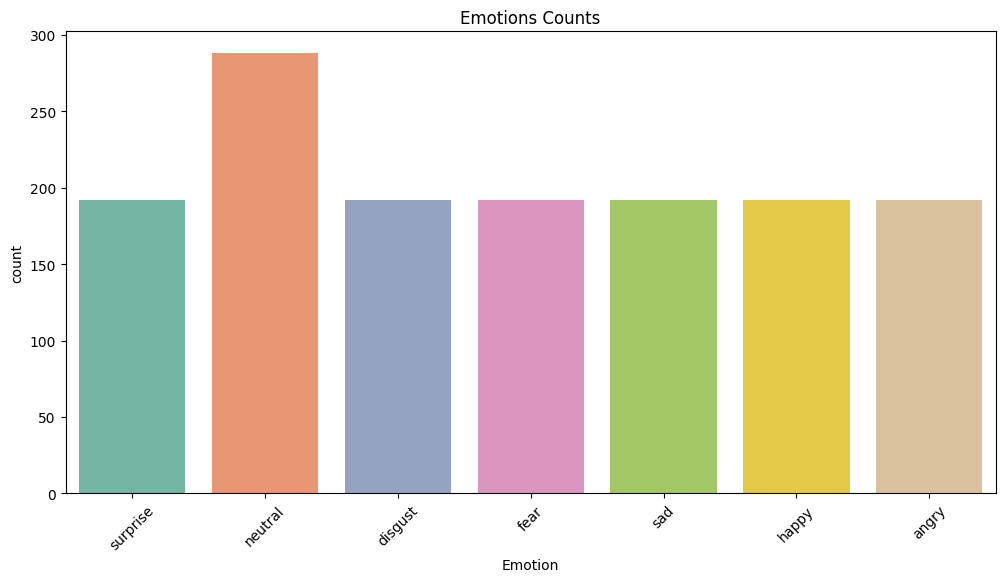

In [108]:
plt.figure(figsize=(12,6))
plt.title('Emotions Counts')
emotions=sns.countplot(x='Emotion',data=main_df,palette='Set2')
emotions.set_xticklabels(emotions.get_xticklabels(),rotation=45)
plt.show()

In [109]:
emotion_names=main_df['Emotion'].unique()

In [110]:
colors={'disgust':'#804E2D','happy':'#F19C0E','sad':'#478FB8','neutral':'#4CB847','fear':'#7D55AA','angry':'#C00808','surprise':'#EE00FF'}

In [111]:
def wave_plot(data,sr,emotion,color):
    plt.figure(figsize=(12,5))
    plt.title(f'{emotion} emotion for waveplot',size=17)
    librosa.display.waveshow(y=data,sr=sr,color=color)

In [112]:
def spectogram(data,sr,emotion):
    audio=librosa.stft(data)
    audio_db=librosa.amplitude_to_db(abs(audio))
    plt.figure(figsize=(12,5))
    plt.title(f'{emotion} emotion for spectogram',size=17)
    librosa.display.specshow(audio_db,sr=sr,x_axis='time',y_axis='hz')

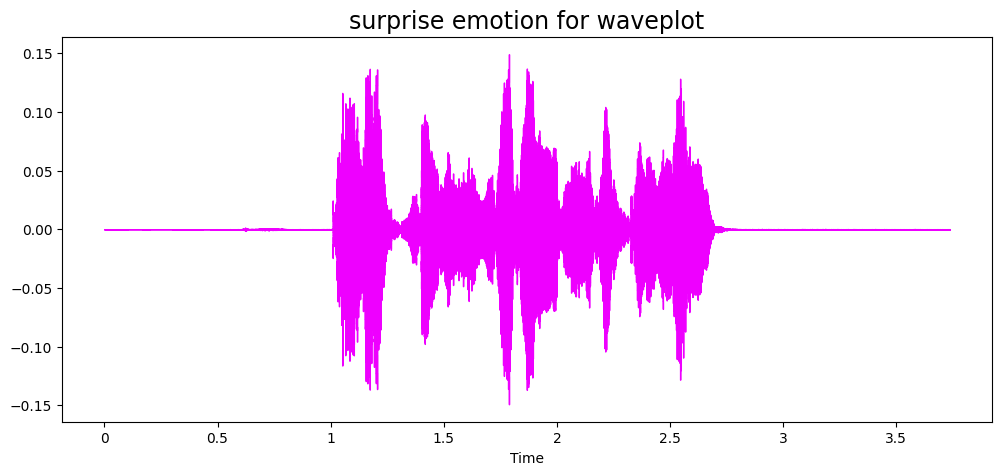

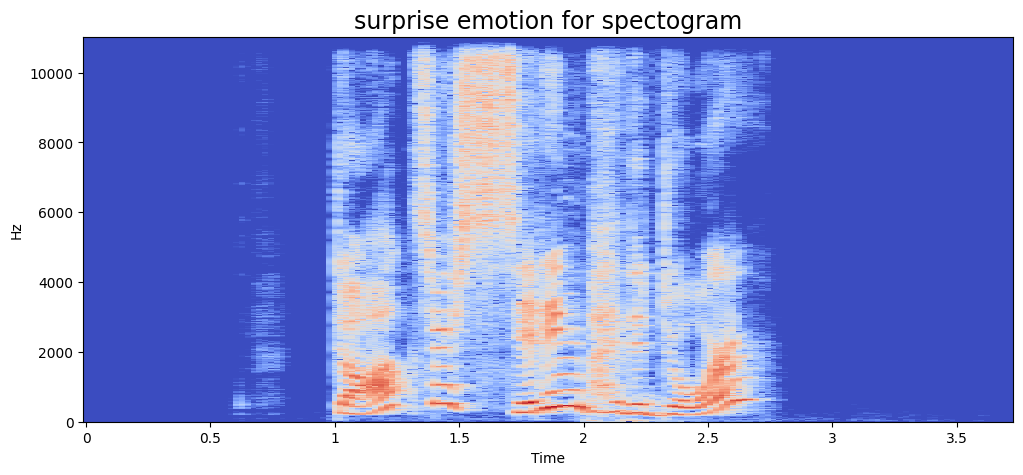

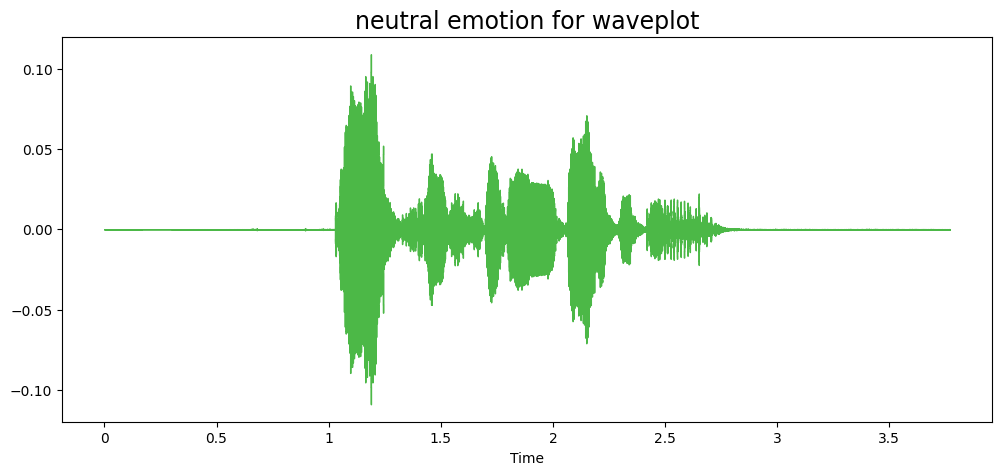

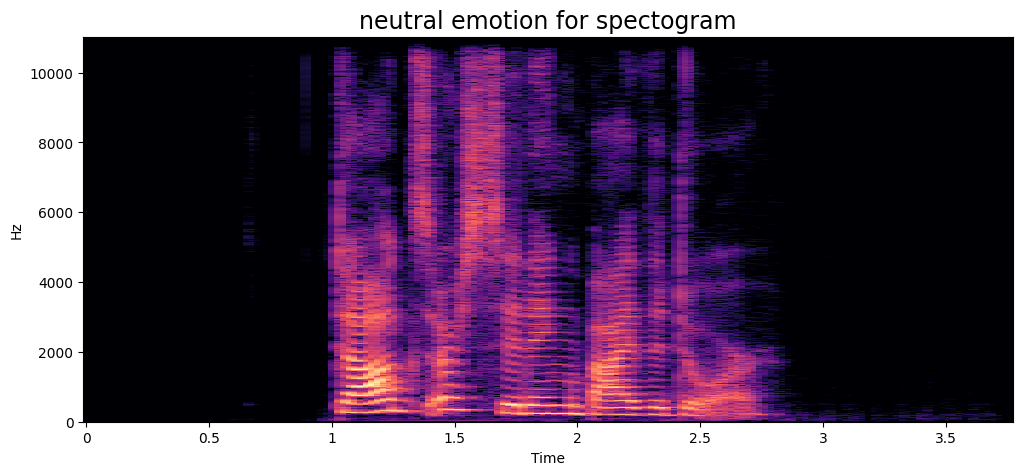

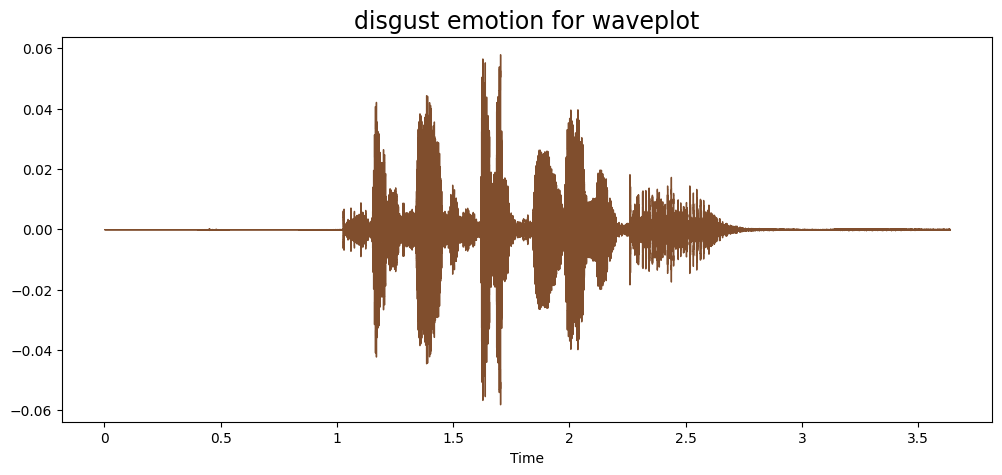

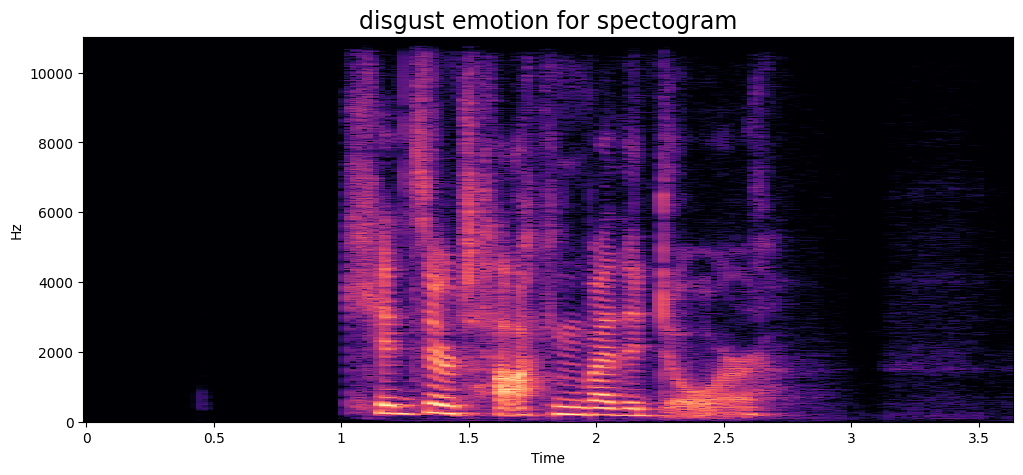

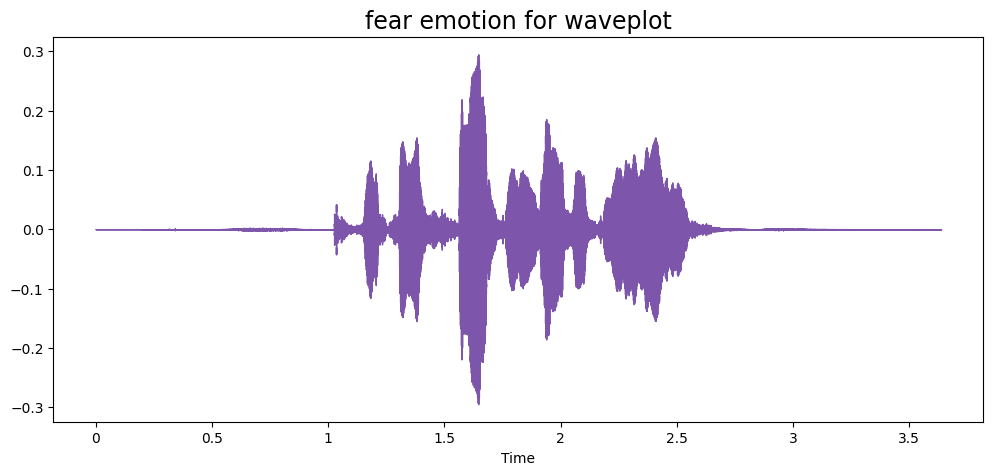

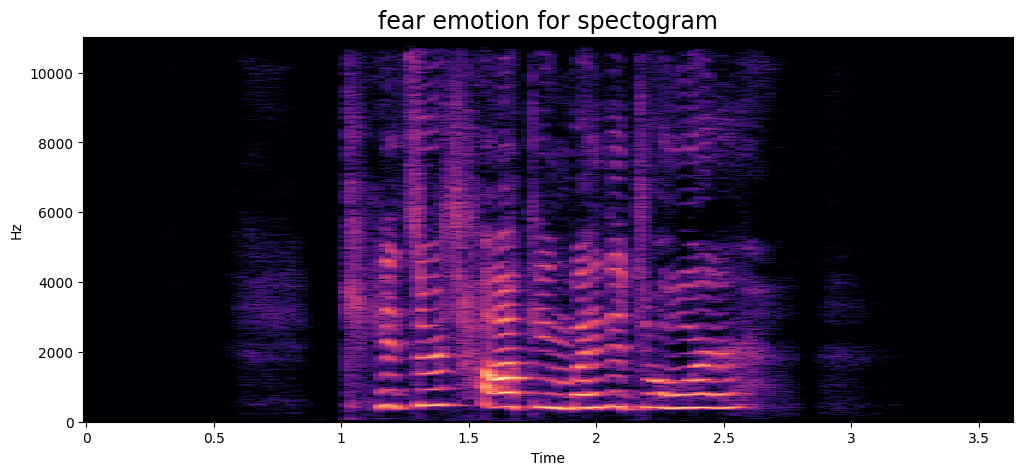

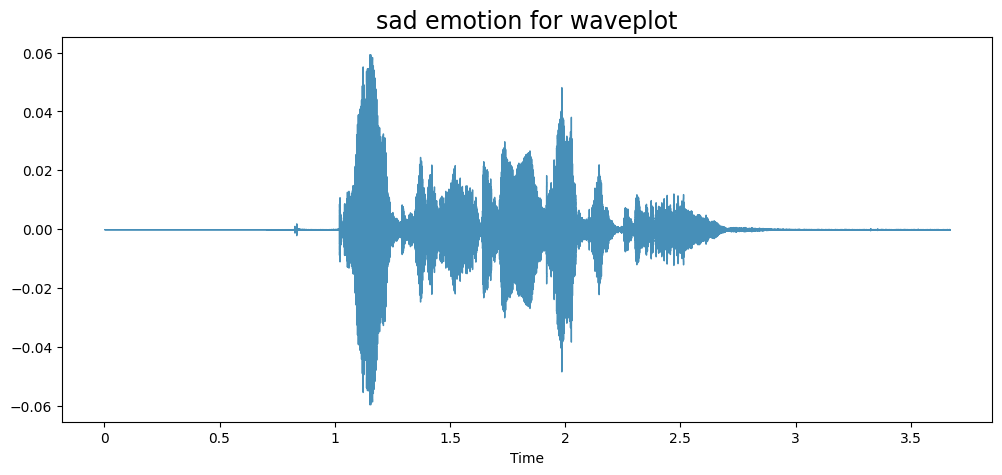

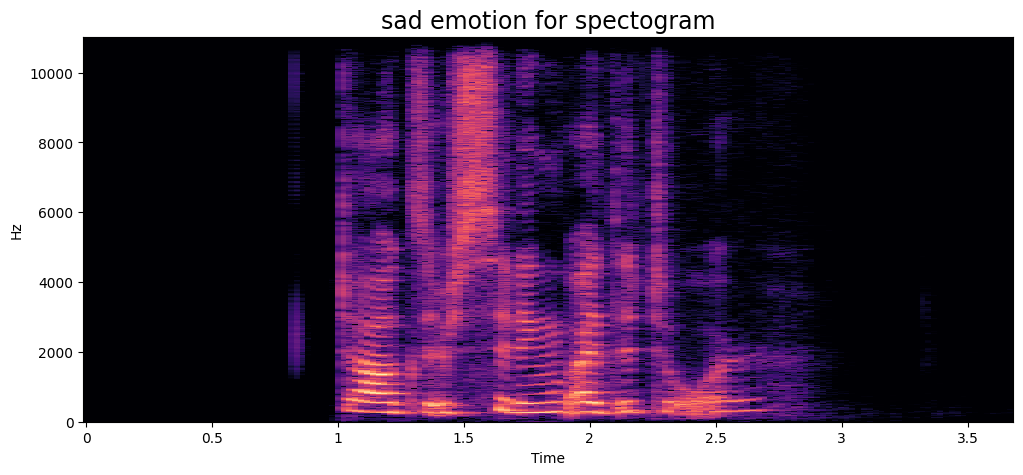

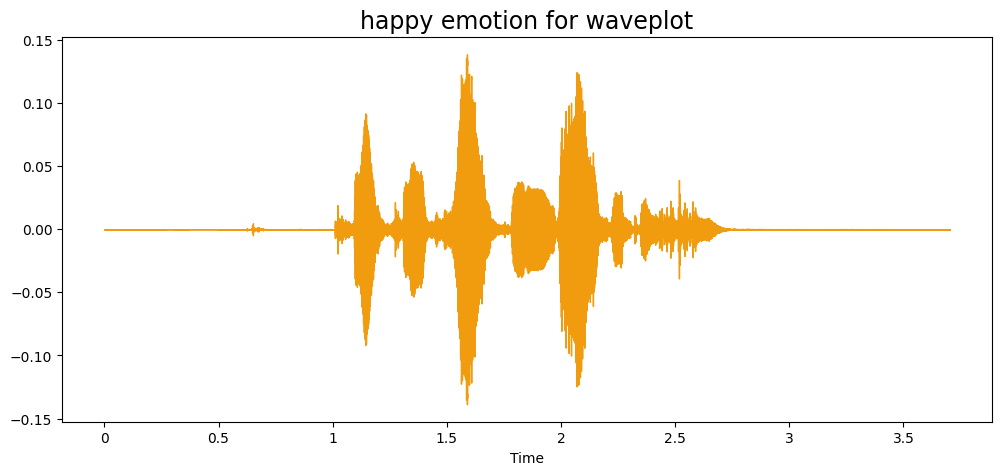

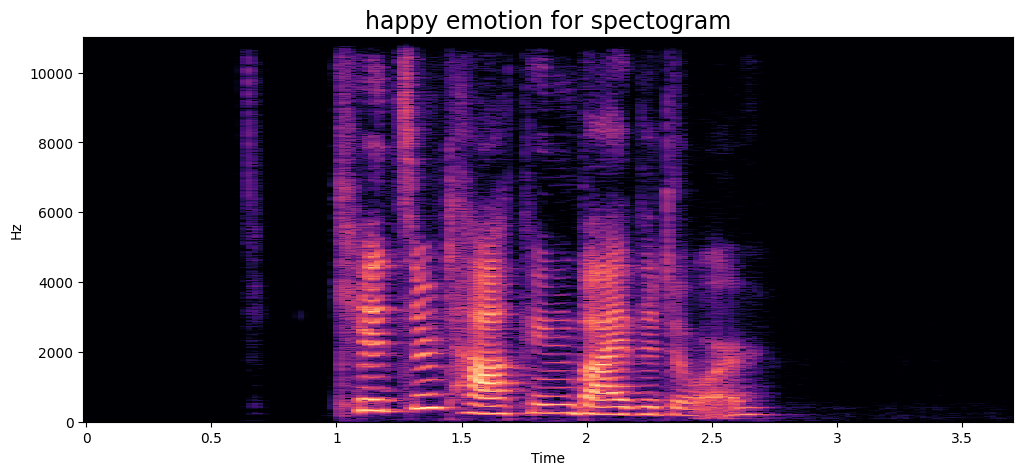

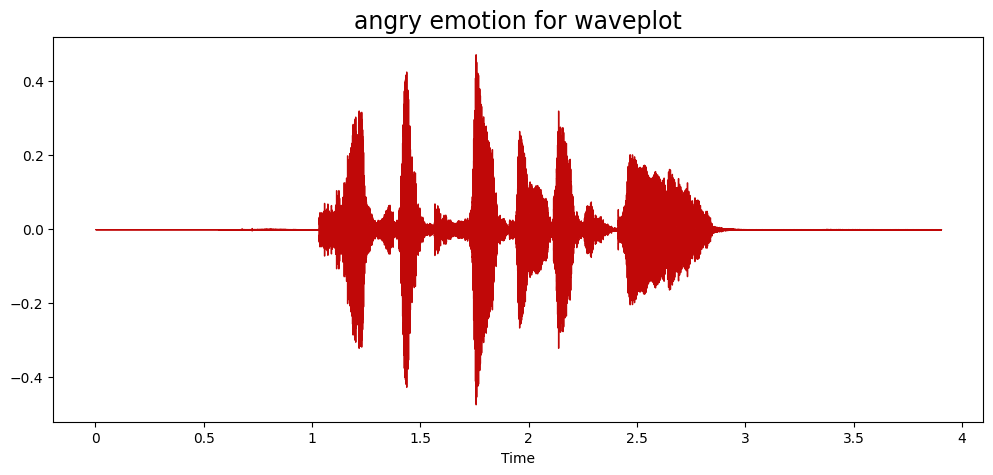

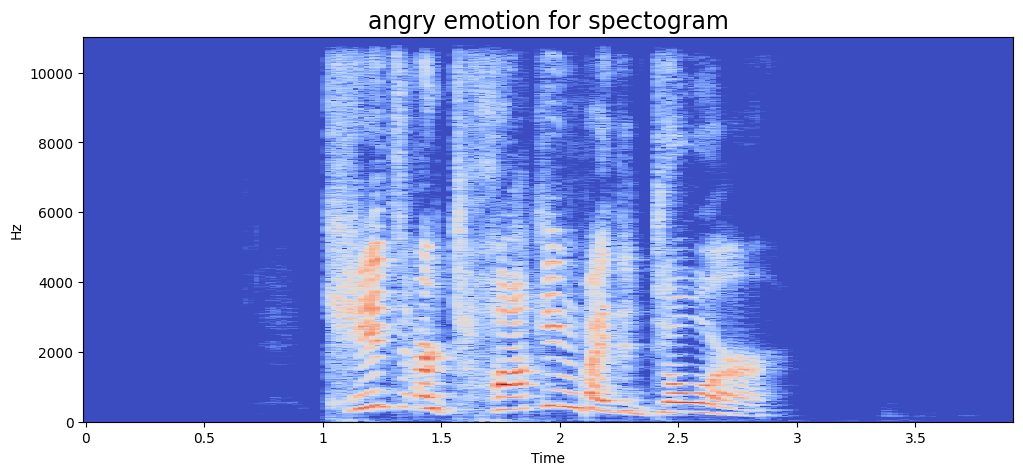

In [113]:
audio_path=[]
for emotion in emotion_names:
    path=np.array(main_df['File_Path'][main_df['Emotion']==emotion])[1]
    data,sr=librosa.load(path)
    wave_plot(data,sr,emotion,colors[emotion])
    spectogram(data,sr,emotion)
    audio_path.append(path)

In [114]:
print('Disgust Audio Sample\n')
IPython.display.Audio(audio_path[0])

Disgust Audio Sample



In [115]:
print('Happy Audio Sample\n')
IPython.display.Audio(audio_path[1])

Happy Audio Sample



In [116]:
print('Sad Audio Sample\n')
IPython.display.Audio(audio_path[2])

Sad Audio Sample



In [117]:
print('Neutral Audio Sample\n')
IPython.display.Audio(audio_path[3])

Neutral Audio Sample



In [118]:
print('Fear Audio Sample\n')
IPython.display.Audio(audio_path[4])

Fear Audio Sample



In [119]:
print('Angry Audio Sample\n')
IPython.display.Audio(audio_path[5])

Angry Audio Sample



In [120]:
print('Surprise Audio Sample\n')
IPython.display.Audio(audio_path[6])

Surprise Audio Sample



<a id="7"></a>
## Audio Augmentation

In [121]:
def add_noise(data,random=False,rate=0.035,threshold=0.075):
    if random:
        rate=np.random.random()*threshold
    noise=rate*np.random.uniform()*np.amax(data)
    augmented_data=data+noise*np.random.normal(size=data.shape[0])
    return augmented_data

def shifting(data,rate=1000):
    augmented_data=int(np.random.uniform(low=-5,high=5)*rate)
    augmented_data=np.roll(data,augmented_data)
    return augmented_data

def pitching(data,sr,pitch_factor=0.7,random=False):
    if random:
        pitch_factor=np.random.random() * pitch_factor
    return librosa.effects.pitch_shift(y=data,sr=sr,n_steps = pitch_factor)

def streching(data,rate=0.8):
    return librosa.effects.time_stretch(y = data,rate= rate)
    
    

In [122]:
data,sr=librosa.load(audio_path[6])

<a id="4"></a>
### Orijinal Audio

<Figure size 1200x500 with 0 Axes>

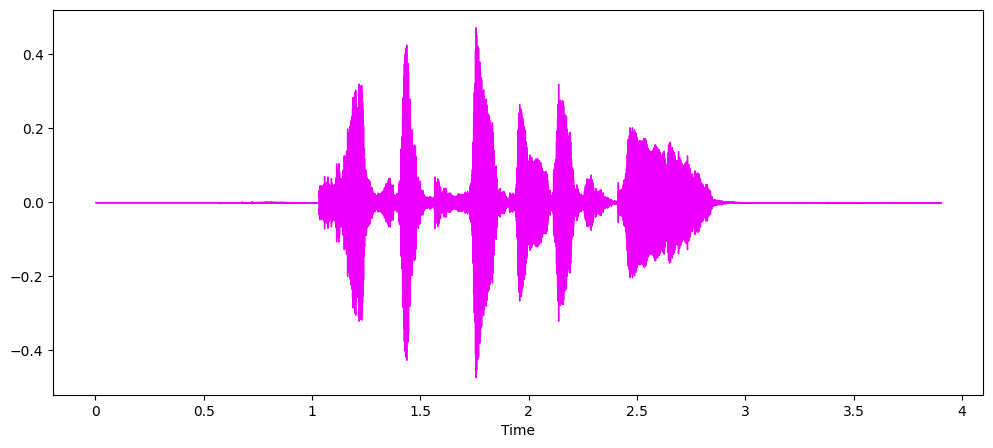

In [123]:
plt.figure(figsize=(12,5))
import librosa.display
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
librosa.display.waveshow(y=data, sr=sr, color='#EE00FF')

IPython.display.Audio(audio_path[6])

<a id="8"></a>
### Noised Audio

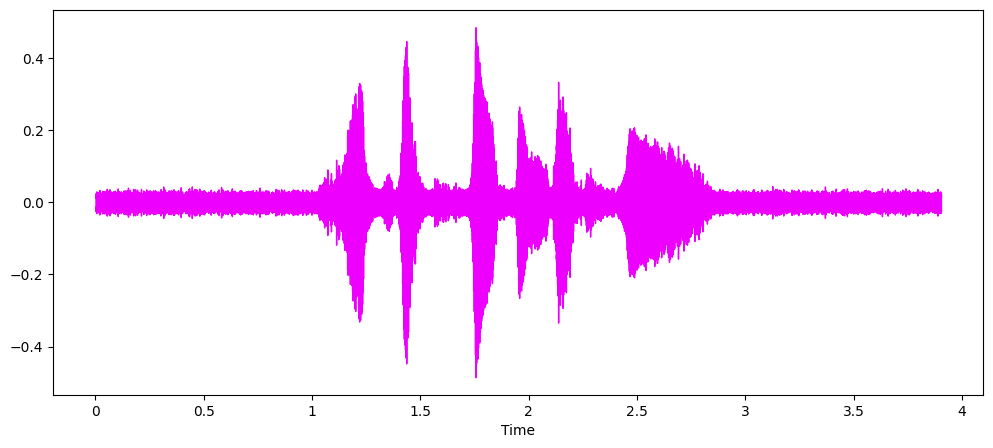

In [124]:
noised_audio=add_noise(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=noised_audio,sr=sr,color='#EE00FF')
IPython.display.Audio(noised_audio,rate=sr)

<a id="10"></a>
### Streched Audio

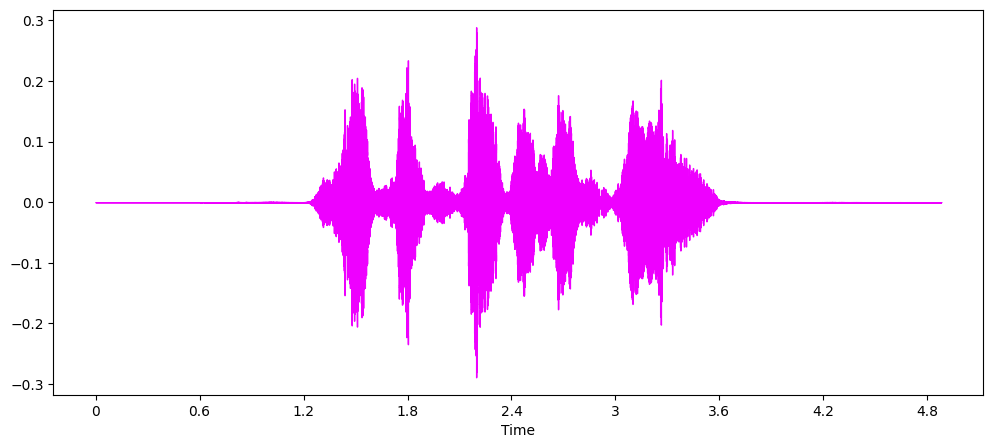

In [125]:
stretched_audio=streching(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y = stretched_audio,sr = sr,color='#EE00FF')
IPython.display.Audio(stretched_audio,rate=sr)

<a id="11"></a>
### Shifted Audio

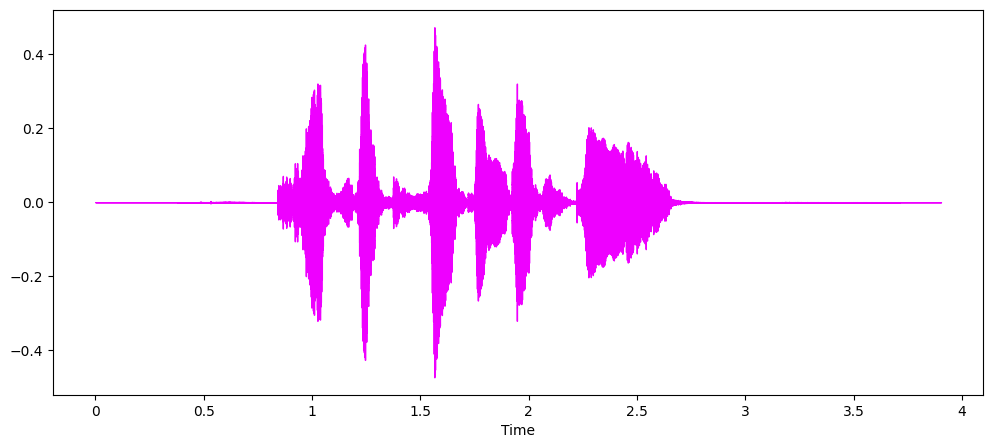

In [126]:
shifted_audio=shifting(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y = shifted_audio,sr = sr,color='#EE00FF')
IPython.display.Audio(shifted_audio,rate=sr)

<a id="12"></a>
### Pitched Audio

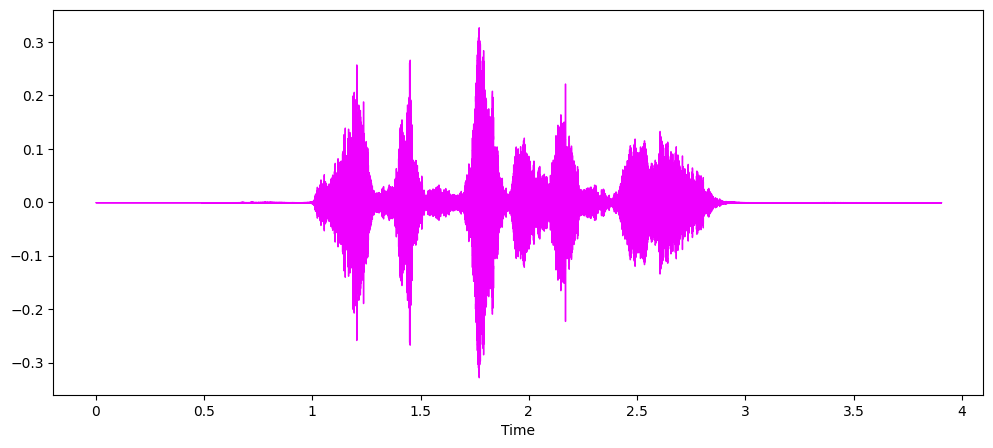

In [127]:
pitched_audio=pitching(data,sr)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y = pitched_audio,sr = sr,color='#EE00FF')
IPython.display.Audio(pitched_audio,rate=sr)

<a id="13"></a>
## Feature Extraction

In [128]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
def rmse(data,frame_length=2048,hop_length=512):
    rmse=librosa.feature.rms(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(rmse)
def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(y=data,sr=sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

def extract_features(data,sr,frame_length=2048,hop_length=512):
    result=np.array([])
    
    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      #rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

def get_features(path,duration=2.5, offset=0.6):
    data,sr=librosa.load(path,duration=duration,offset=offset)
    aud=extract_features(data,sr)
    audio=np.array(aud)
    
    noised_audio=add_noise(data,random=True)
    aud2=extract_features(noised_audio,sr)
    audio=np.vstack((audio,aud2))
    
    pitched_audio=pitching(data,sr,random=True)
    aud3=extract_features(pitched_audio,sr)
    audio=np.vstack((audio,aud3))
    
    pitched_audio1=pitching(data,sr,random=True)
    pitched_noised_audio=add_noise(pitched_audio1,random=True)
    aud4=extract_features(pitched_noised_audio,sr)
    audio=np.vstack((audio,aud4))
    
    return audio
def rmse(data, frame_length=2048, hop_length=512):
    # Specify 'y' as the keyword for data
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)


<a id="14"></a>
## Processing

In [129]:
X,Y=[],[]
for path,emotion,index in zip(main_df.File_Path,main_df.Emotion,range(main_df.File_Path.shape[0])):
    features=get_features(path)
    if index%500==0:
        print(f'{index} audio has been processed')
    for i in features:
        X.append(i)
        Y.append(emotion)
print('Done')

0 audio has been processed
500 audio has been processed
1000 audio has been processed
Done


In [130]:
processed_data_path='./processed_data.csv'

In [131]:
extract=pd.DataFrame(X)
extract['Emotion']=Y
extract.to_csv(processed_data_path,index=False)
extract.head(10)

0         1         2         3         4         5         6  \
0  0.343750  0.479492  0.573730  0.458008  0.375488  0.301758  0.269043   
1  0.246094  0.363281  0.488281  0.472168  0.476074  0.480957  0.470703   
2  0.308105  0.437012  0.535645  0.461426  0.375000  0.312012  0.275879   
3  0.239746  0.362305  0.476074  0.475098  0.485352  0.498535  0.503418   
4  0.437500  0.659668  0.862305  0.878906  0.865234  0.847168  0.845703   
5  0.248535  0.375000  0.501465  0.499023  0.501953  0.502441  0.501953   
6  0.308594  0.429688  0.556641  0.482422  0.454590  0.428223  0.405762   
7  0.252930  0.377930  0.508301  0.505859  0.499512  0.498535  0.487793   
8  0.000000  0.000000  0.000000  0.000000  0.000000  0.063477  0.176758   
9  0.242188  0.361816  0.497559  0.507324  0.511230  0.525391  0.517578   

          7         8         9  ...      2259       2260       2261  \
0  0.255371  0.251465  0.251953  ... -1.517690  -1.716483  -1.599310   
1  0.474121  0.484375  0.488770  ...  3.645155  -4.562435  -6.126077   
2  0.261230  0.253906  0.251465  ... -0.802797   0.572542   2.050323   
3  0.520020  0.512695  0.497070  ... -1.995429  -5.617936   1.594667   
4  0.827637  0.835938  0.667969  ...  2.586417   2.746852   2.223276   
5  0.516602  0.509766  0.512207  ...  1.025884   1.318142   1.050265   
6  0.404785  0.407715  0.413574  ...  3.322855   3.377306   2.670208   
7  0.494141  0.493164  0.492676  ... -3.782087  -1.558656  -3.702489   
8  0.176758  0.254883  0.365723  ... -1.825551 -24.133347  18.153677   
9  0.515625  0.516113  0.506836  ... -8.816990 -10.570971   0.546709   

        2262       2263       2264      2265      2266       2267   Emotion  
0  -1.234609  -0.693198  -0.038982  0.675206  1.405603   2.112303  surprise  
1  -5.467185  -0.530304   1.663612 -3.858787 -1.854246   0.587972  surprise  
2   3.386184   4.403891   5.014430  5.216635  5.081787   4.726884  surprise  
3   2.592857   2.317295  -0.353639  0.459307  5.911402   3.666257  surprise  
4   0.986916  -0.730695  -2.530884 -4.002834 -4.849372  -4.929744   neutral  
5   1.251391   4.879538   8.325338  1.224690  0.733692  -0.817935   neutral  
6   1.274899  -0.550862  -2.422428 -3.910455 -4.639981  -4.390155   neutral  
7  -4.824482  -2.573848  -1.186435  1.464635 -1.346731 -10.448854   neutral  
8 -15.056425  -7.674027 -13.918596 -5.563495 -7.357308  -0.008657   disgust  
9  -0.157053 -12.112968 -11.297490 -7.148671 -1.224714  -1.368527   disgust  

[10 rows x 2269 columns]

<a id="15"></a>
# Including Analyzed Audio Features

In [132]:
df=pd.read_csv(processed_data_path)
df.shape

(5760, 2269)

In [133]:
df=df.fillna(0)
print(df.isna().any())
df.shape

0          False
1          False
2          False
3          False
4          False
           ...  
2264       False
2265       False
2266       False
2267       False
Emotion    False
Length: 2269, dtype: bool


(5760, 2269)

In [134]:
df.head(10)

0         1         2         3         4         5         6  \
0  0.343750  0.479492  0.573730  0.458008  0.375488  0.301758  0.269043   
1  0.246094  0.363281  0.488281  0.472168  0.476074  0.480957  0.470703   
2  0.308105  0.437012  0.535645  0.461426  0.375000  0.312012  0.275879   
3  0.239746  0.362305  0.476074  0.475098  0.485352  0.498535  0.503418   
4  0.437500  0.659668  0.862305  0.878906  0.865234  0.847168  0.845703   
5  0.248535  0.375000  0.501465  0.499023  0.501953  0.502441  0.501953   
6  0.308594  0.429688  0.556641  0.482422  0.454590  0.428223  0.405762   
7  0.252930  0.377930  0.508301  0.505859  0.499512  0.498535  0.487793   
8  0.000000  0.000000  0.000000  0.000000  0.000000  0.063477  0.176758   
9  0.242188  0.361816  0.497559  0.507324  0.511230  0.525391  0.517578   

          7         8         9  ...      2259       2260       2261  \
0  0.255371  0.251465  0.251953  ... -1.517690  -1.716483  -1.599310   
1  0.474121  0.484375  0.488770  ...  3.645155  -4.562435  -6.126077   
2  0.261230  0.253906  0.251465  ... -0.802797   0.572542   2.050323   
3  0.520020  0.512695  0.497070  ... -1.995429  -5.617936   1.594667   
4  0.827637  0.835938  0.667969  ...  2.586417   2.746852   2.223276   
5  0.516602  0.509766  0.512207  ...  1.025884   1.318142   1.050265   
6  0.404785  0.407715  0.413574  ...  3.322855   3.377306   2.670208   
7  0.494141  0.493164  0.492676  ... -3.782087  -1.558656  -3.702489   
8  0.176758  0.254883  0.365723  ... -1.825551 -24.133347  18.153677   
9  0.515625  0.516113  0.506836  ... -8.816990 -10.570971   0.546709   

        2262       2263       2264      2265      2266       2267   Emotion  
0  -1.234609  -0.693198  -0.038982  0.675206  1.405603   2.112303  surprise  
1  -5.467185  -0.530304   1.663612 -3.858787 -1.854246   0.587972  surprise  
2   3.386184   4.403891   5.014430  5.216635  5.081787   4.726884  surprise  
3   2.592857   2.317295  -0.353639  0.459307  5.911402   3.666257  surprise  
4   0.986916  -0.730695  -2.530884 -4.002834 -4.849372  -4.929744   neutral  
5   1.251391   4.879538   8.325338  1.224690  0.733692  -0.817935   neutral  
6   1.274899  -0.550862  -2.422428 -3.910455 -4.639981  -4.390155   neutral  
7  -4.824482  -2.573848  -1.186435  1.464635 -1.346731 -10.448854   neutral  
8 -15.056425  -7.674027 -13.918596 -5.563495 -7.357308  -0.008657   disgust  
9  -0.157053 -12.112968 -11.297490 -7.148671 -1.224714  -1.368527   disgust  

[10 rows x 2269 columns]

<a id="16"></a>
# Processing Analyzed Data for Training

In [135]:
X=df.drop(labels='Emotion',axis=1)
Y=df['Emotion']

In [136]:
lb=LabelEncoder()
#Y=np_utils.to_categorical(lb.fit_transform(Y))
Y=to_categorical(lb.fit_transform(Y))
print(lb.classes_)
Y

['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

<a id="17"></a>
## Train, Test and Validation Spliting

In [137]:
X_train,X_test,y_train,y_test=train_test_split(X,Y,random_state=42,test_size=0.2,shuffle=True)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((4608, 2268), (1152, 2268), (4608, 7), (1152, 7))

In [138]:
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,random_state=42,test_size=0.1,shuffle=True)
X_train.shape, X_test.shape, X_val.shape, y_train.shape,y_test.shape,y_val.shape

((4147, 2268), (1152, 2268), (461, 2268), (4147, 7), (1152, 7), (461, 7))

In [139]:
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)
X_val=scaler.transform(X_val)
X_train.shape,X_test.shape,X_val.shape,y_train.shape,y_test.shape,y_val.shape

((4147, 2268), (1152, 2268), (461, 2268), (4147, 7), (1152, 7), (461, 7))

In [140]:
X_train=np.expand_dims(X_train,axis=2)
X_val=np.expand_dims(X_val,axis=2)
X_test=np.expand_dims(X_test,axis=2)
X_train.shape, X_test.shape, X_val.shape

((4147, 2268, 1), (1152, 2268, 1), (461, 2268, 1))

<a id="18"></a>
## Tuning for Training

In [141]:
early_stop=EarlyStopping(monitor='val_acc',mode='auto',patience=5,restore_best_weights=True)
lr_reduction=ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.5,min_lr=0.00001)

In [142]:
EPOCH=100
BATCH_SIZE=64

<a id="19"></a>
# Begin Training

In [143]:
mode1l=tf.keras.Sequential([
    L.Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(X_train.shape[1],1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    L.Conv1D(512,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    L.Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    L.Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    L.Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3,strides=2,padding='same'),
    L.Flatten(),
    L.Dense(512,activation='relu'),
    L.BatchNormalization(),
    L.Dense(7,activation='softmax')
])
#model.compile(optimizer='adam',loss='categorical_crossentropy',metrics='accuracy')
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 2268, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 2268, 512) │      3,072 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2268, 512) │      2,048 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 1134, 512) │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 1134, 512) │  1,311,232 │ max_pooling1d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1134, 512) │      2,048 │ conv1d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_6     │ (None, 567, 512)  │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 567, 256)  │    655,616 │ max_pooling1d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 567, 256)  │      1,024 │ conv1d_7[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_7     │ (None, 284, 256)  │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 284, 256)  │    196,864 │ max_pooling1d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 284, 256)  │      1,024 │ conv1d_8[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_8     │ (None, 142, 256)  │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 142, 128)  │     98,432 │ max_pooling1d_8[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 142, 128)  │        512 │ conv1d_9[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_9     │ (None, 71, 128)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 71, 128)   │          0 │ max_pooling1d_9[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 71, 128)   │    527,488 │ reshape[0][0],    │
│ (MultiHeadAttentio… │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 71, 128)   │        256 │ multi_head_atten

 Total params: 12,111,879 (46.20 MB)

 Trainable params: 12,107,527 (46.19 MB)

 Non-trainable params: 4,352 (17.00 KB)

In [144]:
import tensorflow as tf
from tensorflow.keras import layers as L
from tensorflow.keras.models import Model

# Define the CNN part
cnn_input = tf.keras.Input(shape=(X_train.shape[1], 1))
x = L.Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu')(cnn_input)
x = L.BatchNormalization()(x)
x = L.MaxPool1D(pool_size=5, strides=2, padding='same')(x)
x = L.Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu')(x)
x = L.BatchNormalization()(x)
x = L.MaxPool1D(pool_size=5, strides=2, padding='same')(x)
x = L.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu')(x)
x = L.BatchNormalization()(x)
x = L.MaxPool1D(pool_size=5, strides=2, padding='same')(x)
x = L.Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu')(x)
x = L.BatchNormalization()(x)
x = L.MaxPool1D(pool_size=5, strides=2, padding='same')(x)
x = L.Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu')(x)
x = L.BatchNormalization()(x)
cnn_output = L.MaxPool1D(pool_size=3, strides=2, padding='same')(x)

# Flatten CNN output for concatenation later
cnn_output_flattened = L.Flatten()(cnn_output)

# Define the Transformer Encoder part
# Input shape matches CNN output for concatenation purposes
transformer_input = L.Reshape((-1, 128))(cnn_output)  # Reshape CNN output to match transformer input
transformer_encoder = L.MultiHeadAttention(num_heads=8, key_dim=128)(transformer_input, transformer_input)
transformer_encoder = L.LayerNormalization()(transformer_encoder)
transformer_output = L.Flatten()(transformer_encoder)  # Flatten for concatenation

# Concatenate CNN and Transformer outputs
concatenated = L.Concatenate()([cnn_output_flattened, transformer_output])

# Dense Layers
x = L.Dense(512, activation='relu')(concatenated)
x = L.BatchNormalization()(x)
output = L.Dense(7, activation='softmax')(x)

# Define and compile the model
model = Model(inputs=cnn_input, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 2268, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 2268, 512) │      3,072 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2268, 512) │      2,048 │ conv1d_15[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_15    │ (None, 1134, 512) │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 1134, 512) │  1,311,232 │ max_pooling1d_15… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1134, 512) │      2,048 │ conv1d_16[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_16    │ (None, 567, 512)  │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 567, 256)  │    655,616 │ max_pooling1d_16… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 567, 256)  │      1,024 │ conv1d_17[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_17    │ (None, 284, 256)  │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_18 (Conv1D)  │ (None, 284, 256)  │    196,864 │ max_pooling1d_17… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 284, 256)  │      1,024 │ conv1d_18[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_18    │ (None, 142, 256)  │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_19 (Conv1D)  │ (None, 142, 128)  │     98,432 │ max_pooling1d_18… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 142, 128)  │        512 │ conv1d_19[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_19    │ (None, 71, 128)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 71, 128)   │          0 │ max_pooling1d_19… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 71, 128)   │    527,488 │ reshape_1[0][0],  │
│ (MultiHeadAttentio… │                   │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 71, 128)   │        256 │ multi_head_atten

 Total params: 12,111,879 (46.20 MB)

 Trainable params: 12,107,527 (46.19 MB)

 Non-trainable params: 4,352 (17.00 KB)

In [145]:
#history=model.fit(X_train, y_train, epochs=EPOCH, validation_data=(X_val,y_val), batch_size=BATCH_SIZE)

In [146]:
#from tensorflow.keras.models import load_model

# Load the model
#model = load_model('/kaggle/working/res_model.h5')


In [147]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define callbacks with appropriate mode
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6)

# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, callbacks=[early_stop, lr_reduction])


Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 26s 284ms/step - accuracy: 0.3042 - loss: 2.8750 - val_accuracy: 0.2061 - val_loss: 5.2389 - learning_rate: 0.0010
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.5053 - loss: 1.3515 - val_accuracy: 0.1128 - val_loss: 3.5405 - learning_rate: 0.0010
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.5902 - loss: 1.1040 - val_accuracy: 0.1432 - val_loss: 3.5736 - learning_rate: 0.0010
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.6855 - loss: 0.8671 - val_accuracy: 0.2364 - val_loss: 3.2560 - learning_rate: 0.0010
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.7881 - loss: 0.6177 - val_accuracy: 0.2191 - val_loss: 3.5277 - learning_rate: 0.0010
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.8655 - loss: 0.4188 - val_accuracy: 0.2516 - val_loss: 4.8435 - learning_rate: 0.0010
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9143 - loss: 0.2828 -

<a id="20"></a>
# Drawing Charts

<a id="21"></a>
## Accuracy Charts

In [148]:
fig=px.line(history.history,y=['accuracy','val_accuracy'],
           labels={'index':'epoch','value':'accuracy'},
           title=f'According to the epoch accuracy and validation accuracy chart for the model with RMSE and MFCC  feature')
fig.show()

<a id="22"></a>
## Loss Charts

In [149]:
fig=px.line(history.history,y=['loss','val_loss'],
           labels={'index':'epoch','value':'loss'},
           title=f'According to the epoch loss and validation loss chart for the model with RMSE and MFCC  feature')
fig.show()

<a id="24"></a>
# Testing Model and Test Results

In [150]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


array([1, 4, 6, ..., 0, 1, 2])

In [151]:
y_check=np.argmax(y_test,axis=1)
y_check

array([1, 4, 6, ..., 0, 1, 2])

In [152]:
loss,accuracy=model.evaluate(X_test,y_test,verbose=0)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

Test Loss: 0.41944757103919983
Test Accuracy: 0.8932291865348816


<a id="25"></a>
## Confusion Matrix

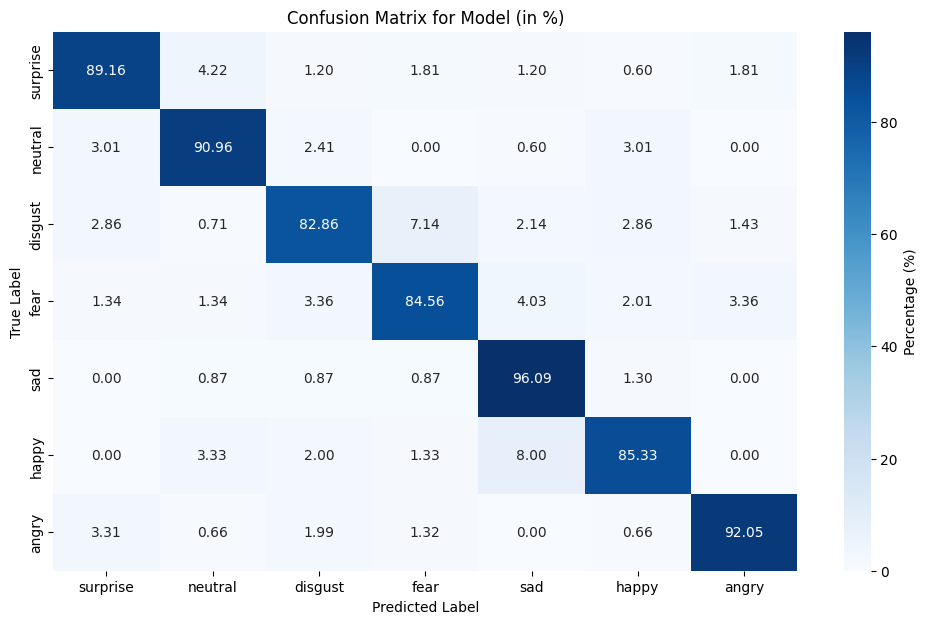

In [153]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
conf = confusion_matrix(y_check, y_pred)

# Normalize the confusion matrix to get percentages
conf_percent = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis] * 100

# Convert the confusion matrix to a DataFrame with labeled rows and columns
cm = pd.DataFrame(
    conf_percent, 
    index=[i for i in emotion_names], 
    columns=[i for i in emotion_names]
)

# Plot the confusion matrix with percentages
plt.figure(figsize=(12, 7))
ax = sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", cbar_kws={'label': 'Percentage (%)'})
ax.set_title('Confusion Matrix for Model (in %)')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.show()


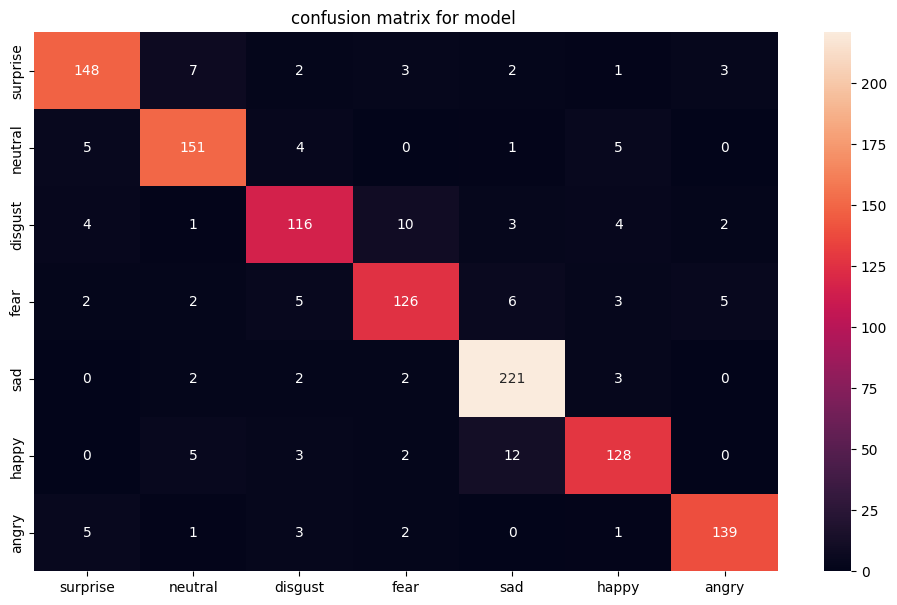

In [154]:
conf=confusion_matrix(y_check,y_pred)
cm=pd.DataFrame(
    conf,index=[i for i in emotion_names],
    columns=[i for i in emotion_names]
)
plt.figure(figsize=(12,7))
ax=sns.heatmap(cm,annot=True,fmt='d')
ax.set_title(f'confusion matrix for model ')
plt.show()

In [155]:
print(f'Model Confusion Matrix\n',classification_report(y_check,y_pred,target_names=emotion_names))

Model Confusion Matrix
               precision    recall  f1-score   support

    surprise       0.90      0.89      0.90       166
     neutral       0.89      0.91      0.90       166
     disgust       0.86      0.83      0.84       140
        fear       0.87      0.85      0.86       149
         sad       0.90      0.96      0.93       230
       happy       0.88      0.85      0.87       150
       angry       0.93      0.92      0.93       151

    accuracy                           0.89      1152
   macro avg       0.89      0.89      0.89      1152
weighted avg       0.89      0.89      0.89      1152



In [156]:
model_path = "./res_model.h5"

model.save(model_path)

In [157]:
main_df=pd.concat([Crema_df,Ravdess_df,Savee_df,Tess_df,Subesco_df],axis=0)